In [1]:
from typing import OrderedDict
from tqdm.notebook import tqdm
import torch
import datasets
import networks


dataset = datasets.LIGOLChirping(
    episode_duration_s=1.0,
    n_sources=1,
    sample_rate_Hz=10000,
    episodes_per_epoch=128,
)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=8,
)

for data, labels in loader:
    print(f"{data.shape=} {data.dtype=}\n{labels.shape=} {labels.dtype=}")
    break

data.shape=torch.Size([64, 1, 16, 418]) data.dtype=torch.float32
labels.shape=torch.Size([64, 1, 5]) labels.dtype=torch.float32


In [2]:
n_params, n_sources = labels.shape[1:]


class ToyModel(torch.nn.Module):
    def __init__(self, n_params, n_sources):
        super().__init__()
        self.conv = networks.ConvNet2d(
            in_channels=1,
            hidden_channels=[16, 16, 16, 16, 16, 16, 16],
            out_channels=n_params * n_sources,
            kernel_size=(3, 7),
        )
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.LazyLinear(n_params * n_sources)
        self.normalize = torch.nn.BatchNorm1d(n_params * n_sources)

    def forward(self, data, labels):
        output = self.linear(self.flatten(self.conv(data)))
        target = self.normalize(self.flatten(labels))
        return output, target


model = ToyModel(n_params=labels.shape[1], n_sources=labels.shape[2])
print(data.shape, model(data, labels)[0].shape)
print(model)

torch.Size([64, 1, 16, 418]) torch.Size([64, 5])
ToyModel(
  (conv): ConvNet2d(
    (0): Conv2d(1, 16, kernel_size=(3, 7), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 16, kernel_size=(3, 7), stride=(2, 4), padding=(1, 3))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(16, 16, kernel_size=(3, 7), stride=(1, 1), padding=same)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(16, 16, kernel_size=(3, 7), stride=(2, 4), padding=(1, 3))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(16, 16, kernel_size=(3, 7), stride=(1, 1), padding=same)
    (13): BatchNorm2d(16, eps=1e-

c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model.train()

losslog = []
for epoch in tqdm(range(100)):
    losslog.append([])
    for data, labels in loader:
        data, labels = data.to(device), labels.to(device)
        output, target = model(data, labels)
        loss = torch.nn.functional.smooth_l1_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losslog[-1].append(loss)
    print(f"epoch {epoch} loss {torch.tensor(losslog[-1]).mean().item():.3f}")

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0 loss 0.517
epoch 1 loss 0.498
epoch 2 loss 0.495
epoch 3 loss 0.493
epoch 4 loss 0.491
epoch 5 loss 0.491
epoch 6 loss 0.474
epoch 7 loss 0.458
epoch 8 loss 0.462
epoch 9 loss 0.458
epoch 10 loss 0.460
epoch 11 loss 0.493
epoch 12 loss 0.489
epoch 13 loss 0.454
epoch 14 loss 0.451
epoch 15 loss 0.457
epoch 16 loss 0.458
epoch 17 loss 0.451
epoch 18 loss 0.452
epoch 19 loss 0.473
epoch 20 loss 0.449
epoch 21 loss 0.445
epoch 22 loss 0.445
epoch 23 loss 0.445
epoch 24 loss 0.444
epoch 25 loss 0.444
epoch 26 loss 0.448
epoch 27 loss 0.443
epoch 28 loss 0.447
epoch 29 loss 0.440
epoch 30 loss 0.440
epoch 31 loss 0.447
epoch 32 loss 0.437
epoch 33 loss 0.434
epoch 34 loss 0.440
epoch 35 loss 0.434
epoch 36 loss 0.434
epoch 37 loss 0.434
epoch 38 loss 0.431
epoch 39 loss 0.437
epoch 40 loss 0.434
epoch 41 loss 0.432
epoch 42 loss 0.435
epoch 43 loss 0.430
epoch 44 loss 0.430
epoch 45 loss 0.431
epoch 46 loss 0.432
epoch 47 loss 0.425
epoch 48 loss 0.430
epoch 49 loss 0.429
epoch 50 l

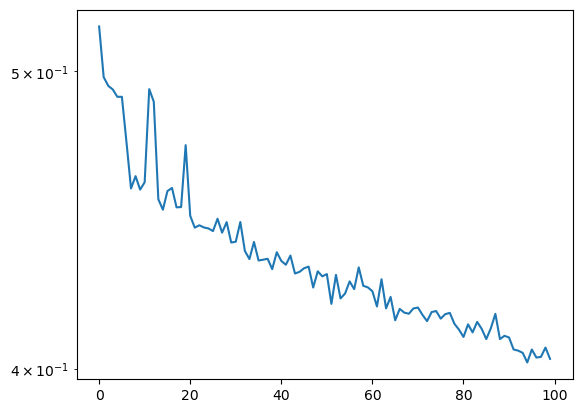

In [10]:
import matplotlib.pyplot as plt
plt.semilogy(torch.tensor(losslog).mean(dim=1).numpy())